In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("ETL-Data").getOrCreate()

In [3]:
def createDimProduct(data):
    # Select the "ProductKey" column and other columns, and then drop duplicates
    dim_product = data.select("ProductID", "Product", "Category", "Segment", "Unit Cost", "Unit Price").dropDuplicates()
    window_spec = Window.orderBy(col("ProductID"))
    dim_product = dim_product.withColumn("ProductKey", row_number().over(window_spec))
    dim_product = dim_product.select("ProductKey","ProductID", "Product", "Category", "Segment", "Unit Cost", "Unit Price")
    return dim_product


In [4]:
def createDimGeography(data):
    dim_geography = data.select("ZipCode", "City", "State", "Region", "District", "Country").dropDuplicates()
    dim_geography = dim_geography.withColumn("ZipCode", col("ZipCode").cast("string"))
    window_spec = Window.orderBy(col("ZipCode"))
    dim_geography = dim_geography.withColumn("GeographyKey", row_number().over(window_spec))
    dim_geography = dim_geography.select("GeographyKey", "ZipCode", "City", "State", "Region", "District", "Country")
    return dim_geography

In [5]:
def createDimCustomer(data, dim_geography):
    dim_customer = data.select("CustomerID", "Email Name", "ZipCode").dropDuplicates()
    dim_customer = dim_customer.withColumn("ZipCode", dim_customer["ZipCode"].cast("string") )
    window_spec = Window.orderBy(col("CustomerID"))
    dim_customer = dim_customer.withColumn("CustomerKey", row_number().over(window_spec))
    dim_customer = dim_customer.select("CustomerKey", "CustomerID", "Email Name", "ZipCode")
    dim_customer = dim_customer.withColumn("Email", regexp_extract("Email Name", r"\((.*?)\)",1))\
                                .withColumn("Last Name", regexp_extract("Email Name", r": (.*?),",1))\
                                .withColumn("First Name", regexp_extract("Email Name", r", (.*)", 1))
    dim_customer = dim_customer.join(dim_geography, how="left", on="ZipCode")
    dim_customer = dim_customer.select("CustomerKey", "CustomerID", "ZipCode", "Email", "Last Name", "First Name","GeographyKey")
    return dim_customer

In [6]:
def createDimDate(beginDate, endDate):
    # Define beginDate and endDate
    # beginDate = '2011-01-01'
    # endDate = '2023-12-31'
    # Generate a sequence of dates and create a DataFrame
    dim_date = spark.sql(f"SELECT explode(sequence(to_date('{beginDate}'), to_date('{endDate}'), interval 1 day)) as CalendarDate")
    # Create various date attributes
    dim_date = dim_date.withColumn("DateKey", expr("year(CalendarDate) * 10000 + month(CalendarDate) * 100 + day(CalendarDate)"))
    dim_date = dim_date.withColumn("CalendarYear", year("CalendarDate"))
    dim_date = dim_date.withColumn("CalendarMonth", date_format("CalendarDate", "MMMM"))
    dim_date = dim_date.withColumn("MonthOfYear", month("CalendarDate"))
    dim_date = dim_date.withColumn("CalendarDay", date_format("CalendarDate", "EEEE"))
    dim_date = dim_date.withColumn("DayOfWeek", dayofweek("CalendarDate"))
    dim_date = dim_date.withColumn("DayOfWeekStartMonday", expr("weekday(CalendarDate) + 1"))
    dim_date = dim_date.withColumn("IsWeekDay", expr("case when weekday(CalendarDate) < 5 then 'Y' else 'N' end"))
    dim_date = dim_date.withColumn("DayOfMonth", dayofmonth("CalendarDate"))
    dim_date = dim_date.withColumn("IsLastDayOfMonth", expr("case when CalendarDate = last_day(CalendarDate) then 'Y' else 'N' end"))
    dim_date = dim_date.withColumn("DayOfYear", dayofyear("CalendarDate"))
    dim_date = dim_date.withColumn("WeekOfYearIso", weekofyear("CalendarDate"))
    dim_date = dim_date.withColumn("QuarterOfYear", quarter("CalendarDate"))
    # Calculate Fiscal Year Oct to Sep
    dim_date = dim_date.withColumn("FiscalYearOctToSep", expr("case when month(CalendarDate) >= 10 then year(CalendarDate) + 1 else year(CalendarDate) end"))
    dim_date = dim_date.withColumn("FiscalMonthOctToSep", expr("(month(CalendarDate) + 2) % 12 + 1"))
    # Calculate Fiscal Year Jul to Jun
    dim_date = dim_date.withColumn("FiscalYearJulToJun", expr("case when month(CalendarDate) >= 7 then year(CalendarDate) + 1 else year(CalendarDate) end"))
    dim_date = dim_date.withColumn("FiscalMonthJulToJun", expr("(month(CalendarDate) + 5) % 12 + 1"))

    dim_date = dim_date.select("DateKey", "CalendarDate", "CalendarYear", "CalendarMonth", "MonthOfYear", "CalendarDay", "DayOfWeek", "DayOfWeekStartMonday"\
                            , "IsWeekDay", "DayOfMonth", "IsLastDayOfMonth", "DayOfYear", "WeekOfYearIso", "QuarterOfYear", "FiscalYearOctToSep", "FiscalMonthOctToSep"\
                                , "FiscalYearJulToJun", "FiscalMonthJulToJun" )
    # Order the DataFrame by CalendarDate
    dim_date = dim_date.orderBy("CalendarDate")
    return dim_date

In [7]:
def createFact(data, dim_date, dim_customer, dim_product):
    data = data.drop("Unit Cost", "Unit Price")
    data = data.withColumn("Date", to_date(data["Date"], "d/M/yy"))
    data = data.join(dim_date,  col("Date") == col("CalendarDate"), how="left")
    data = data.join(dim_customer, how = "left", on="CustomerID")
    data = data.join(dim_product, how = "left", on="ProductID")
    fact_table =  data.select("ProductKey", "DateKey", "CustomerKey", "Units", "Unit Cost", "Unit Price")
    window_spec = Window.orderBy("CustomerKey","DateKey")
    fact_table = fact_table.withColumn("OrderID", dense_rank().over(window_spec))
    fact_table = fact_table.select("ProductKey", "DateKey", "CustomerKey", "Units", "Unit Cost", "Unit Price", "OrderID")
    return fact_table


In [63]:
def writeSQLServer(table_name, dataFrame):
    server_name = "jdbc:sqlserver://localhost:1433"
    database_name = "DataModeling"
    url = server_name + ";" + "databaseName=" + database_name + ";"

    username = "sa"
    password = "tuine"

    dataFrame.write \
    .format("jdbc") \
    .mode("append") \
    .option("url", url) \
    .option("dbtable", table_name) \
    .option("user", username) \
    .option("password", password) \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver")\
    .save()

In [64]:
def readSQLServer(table_name):
    server_name = "jdbc:sqlserver://localhost:1433"
    database_name = "DataModeling"
    url = server_name + ";" + "databaseName=" + database_name + ";"

    username = "sa"
    password = "tuine"


    jdbcDF = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password)\
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver")\
        .load()
    
    return jdbcDF

In [8]:
data = spark.read.csv("./data/Sales.csv", header = True, inferSchema = True)

dim_product = createDimProduct(data)
dim_geography = createDimGeography(data)
dim_customer = createDimCustomer(data, dim_geography)
dim_date = createDimDate('2011-01-01','2023-12-31')

fact = createFact(data, dim_product=dim_product, dim_customer=dim_customer, dim_date=dim_date)

In [66]:
writeSQLServer("dbo.DimDate", dim_date)

In [67]:
writeSQLServer("dbo.DimGeography", dim_geography)

In [68]:
writeSQLServer("dbo.DimProduct", dim_product)

In [69]:
writeSQLServer("dbo.DimCustomer", dim_customer)

In [70]:
writeSQLServer("dbo.FactSales", fact)

### Report

#### 1. What was the best month for sales in 2016? How much was earned that month?

In [105]:
df_date = fact.join(dim_date, on="DateKey", how="inner")

In [106]:
df_date.show()

+--------+----------+-----------+-----+-----------+----------+-------+------------+------------+-------------+-----------+-----------+---------+--------------------+---------+----------+----------------+---------+-------------+-------------+------------------+-------------------+------------------+-------------------+
| DateKey|ProductKey|CustomerKey|Units|  Unit Cost|Unit Price|OrderID|CalendarDate|CalendarYear|CalendarMonth|MonthOfYear|CalendarDay|DayOfWeek|DayOfWeekStartMonday|IsWeekDay|DayOfMonth|IsLastDayOfMonth|DayOfYear|WeekOfYearIso|QuarterOfYear|FiscalYearOctToSep|FiscalMonthOctToSep|FiscalYearJulToJun|FiscalMonthJulToJun|
+--------+----------+-----------+-----+-----------+----------+-------+------------+------------+-------------+-----------+-----------+---------+--------------------+---------+----------+----------------+---------+-------------+-------------+------------------+-------------------+------------------+-------------------+
|20110215|       192|          1|    1|1

In [107]:
df_date.printSchema()

root
 |-- DateKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- CustomerKey: integer (nullable = true)
 |-- Units: integer (nullable = true)
 |-- Unit Cost: double (nullable = true)
 |-- Unit Price: double (nullable = true)
 |-- OrderID: integer (nullable = false)
 |-- CalendarDate: date (nullable = false)
 |-- CalendarYear: integer (nullable = false)
 |-- CalendarMonth: string (nullable = false)
 |-- MonthOfYear: integer (nullable = false)
 |-- CalendarDay: string (nullable = false)
 |-- DayOfWeek: integer (nullable = false)
 |-- DayOfWeekStartMonday: integer (nullable = false)
 |-- IsWeekDay: string (nullable = false)
 |-- DayOfMonth: integer (nullable = false)
 |-- IsLastDayOfMonth: string (nullable = false)
 |-- DayOfYear: integer (nullable = false)
 |-- WeekOfYearIso: integer (nullable = false)
 |-- QuarterOfYear: integer (nullable = false)
 |-- FiscalYearOctToSep: integer (nullable = false)
 |-- FiscalMonthOctToSep: integer (nullable = true)
 |-- Fisc

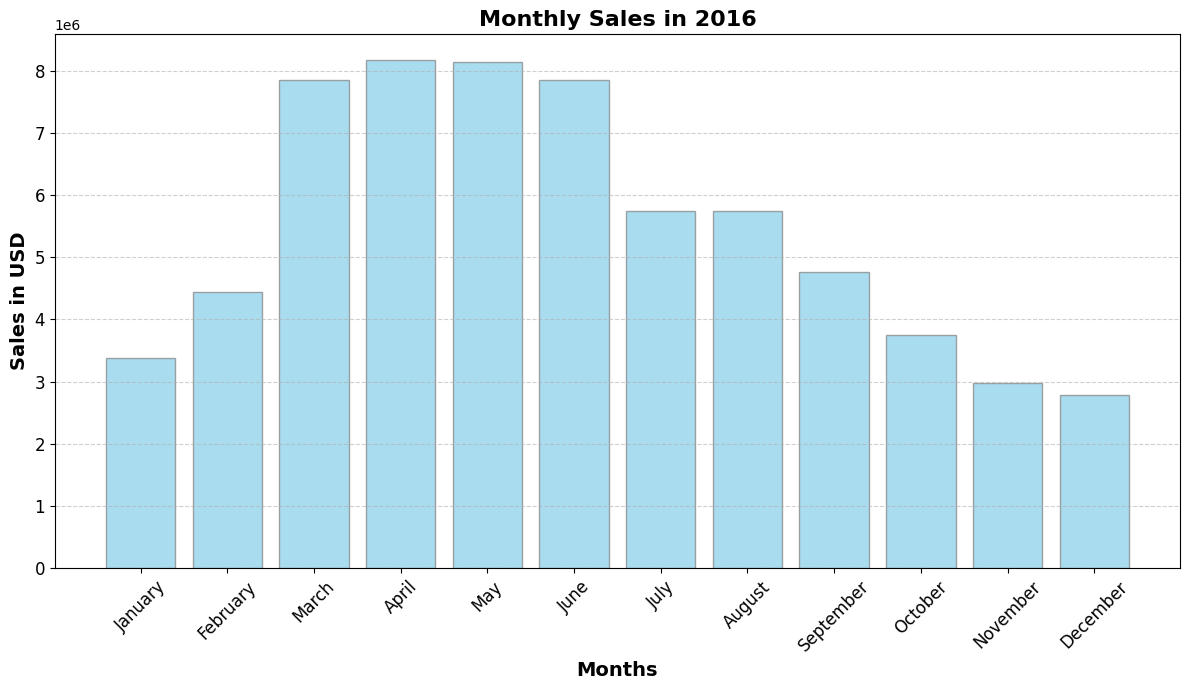

In [116]:

monthly_sales = df_date.withColumn("Sales", col("Units") * col("Unit Price")) \
    .groupBy("CalendarMonth", "MonthOfYear") \
    .agg(sum("Sales").alias("TotalSales"))
monthly_sales = monthly_sales.orderBy("MonthOfYear").drop("MonthOfYear")

months = [row.CalendarMonth for row in monthly_sales.collect()]

sales_values = monthly_sales.select("TotalSales").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 7))
plt.bar(months, sales_values, color='skyblue', edgecolor='gray', alpha=0.7)
plt.xlabel('Months', fontsize=14, fontweight='bold')
plt.ylabel('Sales in USD', fontsize=14, fontweight='bold')
plt.title('Monthly Sales in 2016', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 2. What state has the best sales?

In [9]:
df_customer = fact.join(dim_customer, on="CustomerKey", how="inner")

df_geography = df_customer.join(dim_geography, on="GeographyKey", how="inner")

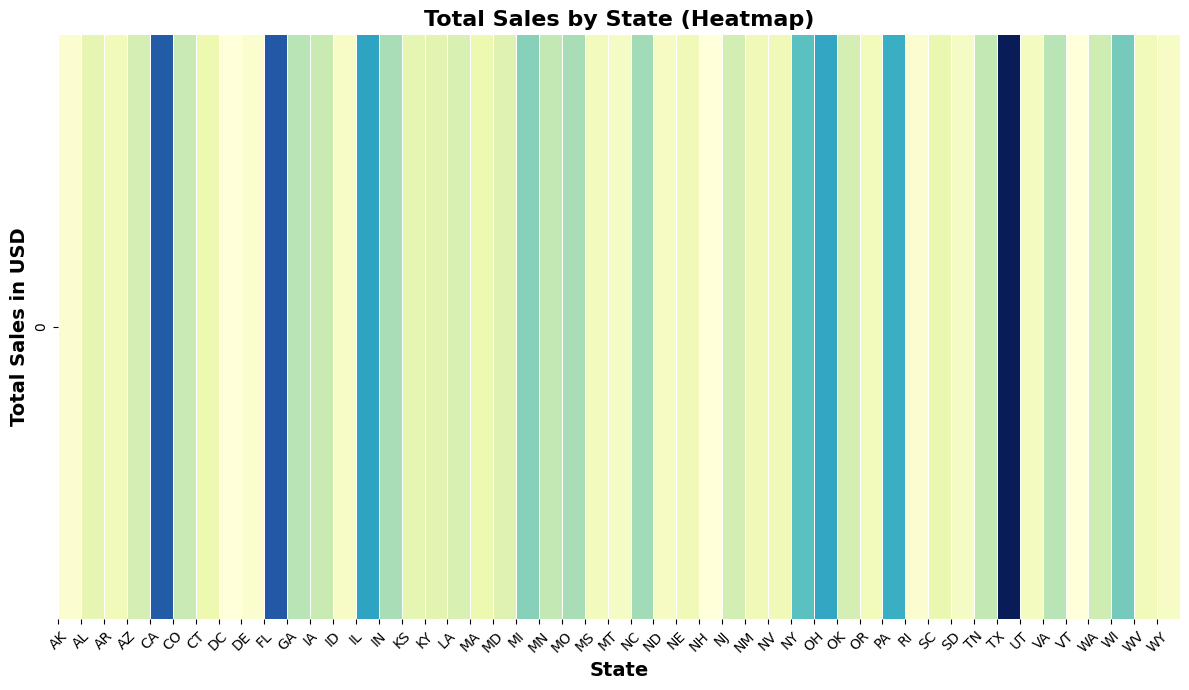

In [17]:
# Calculate sales (Units * Unit Price) and group by State
state_sales = df_geography.withColumn("Sales", col("Units") * col("Unit Price")) \
    .groupBy("State") \
    .agg(sum("Sales").alias("TotalSales"))

# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = state_sales.groupBy().pivot("State").agg(max("TotalSales")).fillna(0)

cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Extract state names
state_names = heatmap_data.columns

# Convert to Pandas DataFrame for plotting with Seaborn
heatmap_df = heatmap_data.toPandas()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_df, cmap="YlGnBu", annot=False, fmt=".2f", linewidths=0.5, cbar=False)
plt.xlabel('State', fontsize=14, fontweight='bold')
plt.ylabel('Total Sales in USD', fontsize=14, fontweight='bold') 
plt.title('Total Sales by State (Heatmap)', fontsize=16, fontweight='bold')
plt.xticks(range(len(state_names)), state_names, rotation=45)
plt.tight_layout()
plt.show()